# ACD Models

**This notebook is written in python 3 **

Louis Echard - 42355

We want to use ACD like models to predict the information (tick) arrival time. 

The standard ACD Model looks like this :
$\psi(i) = \alpha_0 + \sum_{0<j=<p} \alpha_j x_{i-j} + \sum_{0=<j=<q} \beta_j \psi_{i-j}$

On which constraints exist.


We want to include shocks on the underlying and trade size in our model

Let's keep it for calls :
With K:Strike, F:Underlying

Moneyness : $ \omega  =  K/F$   

Shocks on the underlying : $ \lambda(F) = Time Weighted TradingVolumePastXTrades  $

Shocks on the Option : $ \lambda(O) =  Time Weighted TradingVolumePastXTrades $

dt : weighted time since volumes by volume

$\psi(i) = \alpha_0 + \sum_{1=<j=<p} \alpha_j log(x_{i-j}) + \sum_{0=<j=<q} \beta_j \psi_{i-j} + \sum_{0=<j=<s} \gamma_j \omega_{i-j} \lambda (O)_{i-j}   + \sum_{0=<j=<r} \delta_j \omega_{i-j} \lambda (U)_{i-j}$

As proposed by Bauwens and Giot (2000) we can take the logs to avoid constraints on the variables (keep stationarity)

In [1]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path

from pandas.plotting import parallel_coordinates
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [3]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [4]:
#load the data
#data = json.load(open('feeddata_10.json'))

#cleaner : keeps the file compressed on the computer
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [74]:
#(datetime.utcfromtimestamp(data[0]["created"]/1000000))

# I. Typical ACD Model on Futures:
I didn't delete it, but this was a test, you can skip this part

In [4]:
#test of EACD on futures

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]    
    
    initialized = False
    first = True
    for idx, tick in enumerate(data):
    
        myBook = tick["book"]
           
        if myBook[5] == '1' and  tick['type']=='tick':   #let's forget about mini futures
            myContract = getBookContract(myBook[8:11],myBook[3])
    
            if myContract is CONTRACTTYPE.FUTURE:
                if initialized and not first :

                    #calculate alphas and betas parts
                    alphaSum = 0.0
                    betaSum = 0.0            
                    for idx2,alpha in enumerate(alphas): 
                        #print(xs)
                        alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                    for idx2,beta in enumerate(betas):
                        #print(psis)
                        if len(psis)>idx2:
                            betaSum = betaSum + beta*psis[idx2]

                    expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                    psis.append(expectedTime)
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)


                    errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                    check1.append(expectedTime)
                    check2.append(xs[p])

                elif first:
                    first = False
                else:
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)
                    if len(xs) == p:
                        initialized = True

                myPastTime = datetime.utcfromtimestamp(tick["created"]/1000000)

                #maintain right array size
                if len(xs)>p:
                    xs.pop(0)
                if len(psis)>q:
                    psis.pop(0)  

                if idx > 2000 :
                    break
    #return errs,check1,check2
    return np.average(errs)

In [5]:
#parameters:
alpha0 = 0.0
alphas = [1,1,1,1,1,1]
betas = [1,1,1,1]

params0 = [alpha0] + alphas + betas

### Test on Futures : LSE with constraints

In [6]:
def constraint1(x):
    return -np.sum(x)+len(x)

cons = (
            {'type': 'ineq',
             'fun' : constraint1
            }
          ,
              {'type': 'ineq',
               'fun' : lambda x: x
              }
        )

In [78]:

optimize.minimize(residualTotalEACD,params0,args=([len(alphas), len(betas)]), method='COBYLA', constraints=cons, options={'maxiter':10000})

     fun: 1987.1733927191476
   maxcv: 1.0135269667632516e-19
 message: 'Optimization terminated successfully.'
    nfev: 8687
  status: 1
 success: True
       x: array([  1.34372277e+00,  -9.46518187e-20,  -7.80014531e-21,
        -9.89682264e-20,  -9.51935771e-20,  -1.00768977e-19,
         2.65618311e-01,   3.67002166e-01,   7.79119699e-22,
         2.93608638e-01,  -1.01352697e-19])

In [79]:
# we just check what we would get with random variables
paramsTest = [1,1,1]

for idx,param in enumerate(paramsTest):
    paramsTest[idx] = paramsTest[idx]*(np.random.rand()*5)
print(residualTotalEACD(paramsTest, [len(alphas), len(betas)]))
print(paramsTest)

177630.040866
[3.8996560249952346, 4.994533817615261, 4.6851179353219985]


# II. New Model :

# Let's calculate the models for an option book, then we can compare the results to some benchmark

In [8]:
#dataExtraction to save calculation during optimization
#only taking the strike of interest and the future
#precalculating tick times

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                
            elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'tick',
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [9]:
#Simple EACD for Options
def residualTotalEACD(params_, pqs_):
    check1 = [] #sanity check
    check2 = [] #sanity check
    
    #variables of Interest:
    errs = [] #our squared errors
    psis = [] #our estimated waiting time
    xs = [] #the real waiting time
    
    
    p = pqs_[0] #number of lags for real waiting time used in calculation
    q = pqs_[1] #number of lags for estimated waiting time used in calculation
    
    alpha0 = params_[0] #constant
    alphas = params_[1:p+1] #parameters for real waiting time
    betas = params_[p+1:q+p+1] #parameters for estimated waiting time
    
    initialized = False # when we have enough lagged examples 
    first = True #the first data point has to be treated differently
    counter = 0 #the counter is just a check
    
    for idx, tick in enumerate(myDataForRun):
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0) #we keep the right size
            if len(psis)>q:
                psis.pop(0)  #we keep the right size
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that

                expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime) #sanity check
                check2.append(xs[p]) #sanity check

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0) #we keep the right size
        if len(psis)>q:
            psis.pop(0)  #we keep the right size


#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [10]:
#ACD model with added impact on current option book and underlying book
def residualTotalModACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    volumeO = []
    volumeF = []
    TO = []
    TF = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    r = pqs_[2]
    s = pqs_[3]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    gammas =  params_[q+p+1:q+p+1+r]
    deltas = params_[q+p+r+1:q+p+r+s+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.FUTURE: 
            volumeF.append(tick['volume'])
            TF.append(tick['received'])
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.CALL: 
            volumeO.append(tick['volume'])
            TO.append(tick['received'])
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
            if len(volumeO)>r:
                volumeO.pop(0)
                TO.pop(0)
            if len(volumeF)>s:
                volumeF.pop(0)  
                TF.pop(0)
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that
                for idx2,gamma in enumerate(gammas):
                        gammaSum = gammaSum + gamma*volumeO[idx2]*(tick['received']-TO[idx2]).microseconds/1000
                for idx2,delta in enumerate(deltas):
                        deltaSum = deltaSum + delta*volumeF[idx2]*(tick['received']-TF[idx2]).microseconds/1000

                expectedTime = alpha0 + alphaSum +  betaSum + gammaSum + deltaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p and len(volumeO) == r and len(volumeF) == s:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  
        if len(volumeO)>r:
            volumeO.pop(0)
            TO.pop(0)
        if len(volumeF)>s:
            volumeF.pop(0)  
            TF.pop(0)

#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [11]:
#@deprecated

# #parameters:
# alpha0 = 0.0
# alphas = [.01,.01,.01,.01,.01,.01]
# betas = [.01,.01,.01,.01]
# gammas = [.01,.01]
# deltas = [.01,.01]
# params0 = [alpha0] + alphas + betas + gammas + deltas
# #errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))

# p = len(alphas)
# q = len(betas)
# r = len(gammas)
# s = len(deltas)

# alpha0 = params_[0]
# alphas = params_[1:p+1]
# betas = params_[p+1:q+p+1]
# gammas =  params_[q+p+1:q+p+1+r]
# deltas = params_[q+p+r+1:q+p+r+s+1]


In [12]:
nbOfDataPoints=10000

In [13]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data2017110110 = json.loads(f.read().decode("ascii"))

In [14]:
#extract interesting data, of x dataPoints for the specified strike

myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

In [12]:
#function giving initial parameters and parameters size for both ACD models
def initParams(isSimpleACD, isSize):
    alpha0 = 0.0
    alphas = [.001,.001,.001,.001,.001,.001]
    betas = [.001,.001,.001,.001]
    gammas = [.001,.001]
    deltas = [.001,.001]
    if not isSize:
        if isSimpleACD:
            return [alpha0] + alphas + betas
        else:
            return [alpha0] + alphas + betas + gammas + deltas
    elif isSize:
        if isSimpleACD:
            return [len(alphas), len(betas)]
        else:
            return [len(alphas), len(betas), len(gammas), len(deltas)]


In [253]:
#test of running time 1
start_time = timeit.default_timer()
print(residualTotalModACD(initParams(False, False),initParams(False, True)))
print('takes ' + str(timeit.default_timer() - start_time) + ' seconds to run')

6718.16877033
takes 0.02806170029361965 seconds to run


In [256]:
#test of running time 2
paramsTest = initParams(False, False)
for i in range(0,10):
    for idx,param in enumerate(paramsTest):
        paramsTest[idx] = param*np.random.rand()*1.2
        start_time = timeit.default_timer()
    print(residualTotalModACD(paramsTest,initParams(False, True)))
    print("execution time in ms:",(timeit.default_timer() - start_time)*1000)


6817.13715912
execution time in ms: 27.716222743038088
6870.83259507
execution time in ms: 28.839939055615105
6877.38350975
execution time in ms: 28.01366989297094
6876.31017089
execution time in ms: 28.00830608975957
6882.9621161
execution time in ms: 27.8671406013018
6884.18156835
execution time in ms: 27.916633855056716
6879.97258666
execution time in ms: 27.84080921264831
6898.78442167
execution time in ms: 27.98928897755104
6904.70797411
execution time in ms: 28.25528474568273
6907.6133578
execution time in ms: 28.25650379236322


In [13]:
#benchmark n1 : 
#assume the next arrival time is equal to the last one
#e.g. we had to wait 10ms to get a new tick, we expect the next tick will come in 10ms
def residualSamePace() : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun): 
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
            
    return np.mean(errs)

#benchmark n2 : 
#assume the next arrival time is an exponential moving average of the last ones
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

### evaluate benchmarks

In [224]:

#benchmark 1 : next tick arrives at same pace as the last
res_bench1_10 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1_10, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2_10 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2_10.fun, " with best solution x: ", res_bench2_10.x)


The squared errors for the flat arrival time is : 9165.69596874 



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply


The squared errors for the flat arrival time is : 5799.129861051124  with best solution x:  [ 0.90730825]


In [225]:
#benchmark 3 : next tick arrives with EACD model
res_bench3_10 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5324.841356137033
     jac: array([-0.00201416,  0.00189209,  0.00268555, -0.00268555,  0.00305176,
        0.00073242, -0.00128174,  0.06115723, -0.04602051,  0.02313232,
        0.03289795])
 message: 'Optimization terminated successfully.'
    nfev: 914
     nit: 66
    njev: 66
  status: 0
 success: True
       x: array([ 0.07797459, -0.43128864,  1.74987552, -6.01700823, -2.52349263,
       -1.19280172,  8.63008568, -0.54785057,  0.79311569,  0.3707796 ,
        0.37626312])


In [226]:
res_ModACD_10 = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5342.030770750242
     jac: array([  3.05175781e-04,  -2.31933594e-03,   4.82177734e-03,
        -2.50244141e-03,   4.15039062e-03,  -4.88281250e-04,
         2.99072266e-03,   5.52368164e-02,  -7.44628906e-03,
         5.82275391e-02,   6.10351562e-05,   5.80505371e-01,
         6.92626953e-01,   3.68688965e+00,  -3.34472656e-01])
 message: 'Optimization terminated successfully.'
    nfev: 1100
     nit: 61
    njev: 61
  status: 0
 success: True
       x: array([  2.44706826e+01,   2.92287726e-01,   3.42689325e+00,
         2.26281373e+00,   3.54420058e+00,   1.14820347e+01,
         8.96698453e+00,  -1.22344439e-01,   2.03879461e-01,
         3.56547302e-02,  -1.07080917e+00,   4.76548904e-03,
         1.40005239e-02,   1.39221772e-04,   9.02945036e-04])


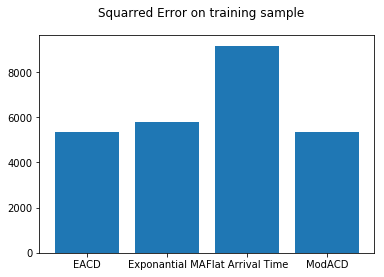

In [227]:
dataToPlot = {'Flat Arrival Time': res_bench1_10, 'Exponantial MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

The squared errors for the flat arrival time is : 3476.43734849 

The squared errors for the flat arrival time is : 

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


2298.915947169761  with best solution x:  [ 0.60064909]
     fun: 1851.261397226359
     jac: array([ 0.00073242, -0.00563049,  0.00469971, -0.0057373 ,  0.00413513,
       -0.00372314,  0.0035553 ,  0.03240967,  0.00485229, -0.00944519,
       -0.00817871])
 message: 'Optimization terminated successfully.'
    nfev: 735
     nit: 53
    njev: 53
  status: 0
 success: True
       x: array([ 6.32253267,  0.2410081 , -2.0991684 ,  0.1753158 ,  1.73915648,
        2.07208888,  3.14091887,  0.85159355,  0.11067023, -0.13064207,
       -0.36373694])


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 1822.0051264135705
     jac: array([ -5.49316406e-04,  -7.17163086e-04,  -2.59399414e-04,
         2.28881836e-04,  -9.30786133e-04,  -9.15527344e-05,
        -6.25610352e-04,  -5.26428223e-03,  -3.63159180e-03,
        -1.03149414e-02,  -1.40533447e-02,  -8.18283081e-01,
         2.92053223e-02,  -6.77185059e-02,  -3.42971802e-01])
 message: 'Optimization terminated successfully.'
    nfev: 835
     nit: 46
    njev: 46
  status: 0
 success: True
       x: array([  2.46285476e+01,   5.21709219e-01,   4.04734355e-01,
         1.87420941e+00,   3.41376920e+00,   2.92913613e+00,
         3.18007819e+00,   9.78344281e-02,  -1.93664727e-01,
        -5.42541709e-01,  -6.63397297e-01,   2.01239343e-03,
         4.89425024e-03,   3.88181876e-03,   3.70921505e-03])


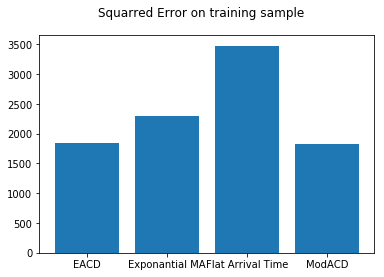

In [228]:
#testing on different window
with gzip.open('data\\2017.11.01\\feeddata_09.json.gz', "rb") as f:
    data2017110109 = json.loads(f.read().decode("ascii"))
    
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data11)

#benchmark 1 : next tick arrives at same pace as the last
res_bench1 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

#benchmark 3 : next tick arrives with EACD model
res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3)
res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD)

dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponantial MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

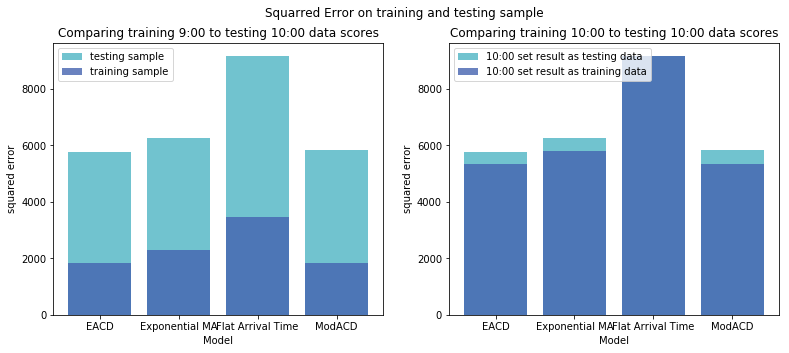

In [229]:
#let's test the data trained on 10am on the 09am set
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

residualSamePace()

dataToPlot1 = {'Flat Arrival Time': residualSamePace(), 'Exponential MA': residualExpoMovingAverage(res_bench2.x), 'EACD': residualTotalEACD(res_bench3.x,initParams(True,True)), 'ModACD': residualTotalModACD(res_ModACD.x,initParams(False,True))}
names1 = list(dataToPlot1.keys())
values1 = list(dataToPlot1.values())

dataToPlot2 = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names2 = list(dataToPlot2.keys())
values2 = list(dataToPlot2.values())

dataToPlot3 = {'Flat Arrival Time': res_bench1_10, 'Exponential MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names3 = list(dataToPlot3.keys())
values3 = list(dataToPlot3.values())

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].bar(names1, values1, color = "#139caf", alpha = 0.6, label = "testing sample")
axs[0].bar(names2,values2, color = '#4563b0', alpha = 0.8, label = "training sample")
axs[0].set_ylabel("squared error")
axs[0].set_xlabel("Model")
axs[0].set_title("Comparing training 9:00 to testing 10:00 data scores")
axs[0].legend(loc = 'upper left')

axs[1].bar(names1,values1, color = "#139caf" , alpha = 0.6, label = "10:00 set result as testing data")
axs[1].bar(names3, values3, color ='#4563b0' , alpha = 0.8, label = "10:00 set result as training data")
axs[1].set_ylabel("squared error")
axs[1].set_xlabel("Model")
axs[1].set_title("Comparing training 10:00 to testing 10:00 data scores")
axs[1].legend(loc = 'upper left')

fig.suptitle('Squarred Error on training and testing sample')

plt.show()

#### We can see that the testing sample has naturally more variance than the training sample (Flat Arrival Time is not being trained). We can however see that the EACD and Mod ACD fail to be very performant in comparison with a simpler model (exponential MA).

In [49]:
result = pd.DataFrame()
paramLearn = pd.DataFrame()

In [54]:
#testing on different window
# # result = pd.DataFrame()
# paramLearn = pd.DataFrame()
for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_13.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_13.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)

        #benchmark 1 : next tick arrives at same pace as the last
        res_bench1 = residualSamePace()
    #     print("The squared errors for the flat arrival time is :",res_bench1, "\n")
        #benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
        res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
    #     print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

        #benchmark 3 : next tick arrives with EACD model
        res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
    #     print(res_bench3)
        res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
    #     print(res_ModACD)

    #     dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
    #     names = list(dataToPlot.keys())
    #     values = list(dataToPlot.values())

    #     fig, axs = plt.subplots()
    #     axs.bar(names, values)
    #     fig.suptitle('Squarred Error on training sample')

    #     plt.show()
        s0 = pd.Series([res_bench1], name='Flat Arrival')
        s1 = pd.Series([res_bench2.fun], name='Exponential')
        s2 = pd.Series([res_bench3.fun], name='EACD')
        s3 = pd.Series([res_ModACD.fun], name='ModACD')

        dfTemp = pd.concat([s0, s1, s2, s3], axis=1)

        result = pd.concat([result, dfTemp], axis=0, ignore_index=True)

        p0 = pd.Series([1], name='Flat Arrival')
        p1 = pd.Series(res_bench2.x, name='Exponential')
        p2 = pd.Series([res_bench3.x], name='EACD')
        p3 = pd.Series([res_ModACD.x], name='ModACD')

        dfTemp2 = pd.concat([p0, p1, p2, p3], axis=1)

        paramLearn = pd.concat([paramLearn, dfTemp2], axis=0, ignore_index=True)
    

{'received': 1491192000057504, 'created': 1491192000056681, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 281.95, 'ask_volume_0': 261, 'ask_price_1': 282.0, 'ask_volume_1': 363, 'ask_price_2': 282.05, 'ask_volume_2': 293, 'ask_price_3': 282.1, 'ask_volume_3': 311, 'ask_price_4': 282.15, 'ask_volume_4': 243, 'bid_price_0': 281.9, 'bid_volume_0': 83, 'bid_price_1': 281.85, 'bid_volume_1': 366, 'bid_price_2': 281.8, 'bid_volume_2': 306, 'bid_price_3': 281.75, 'bid_volume_3': 345, 'bid_price_4': 281.7, 'bid_volume_4': 386}
280


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value 

{'received': 1491278400002317, 'created': 1491278400001356, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 282.05, 'ask_volume_0': 189, 'ask_price_1': 282.1, 'ask_volume_1': 346, 'ask_price_2': 282.15, 'ask_volume_2': 317, 'ask_price_3': 282.2, 'ask_volume_3': 285, 'ask_price_4': 282.25, 'ask_volume_4': 295, 'bid_price_0': 282.0, 'bid_volume_0': 108, 'bid_price_1': 281.95, 'bid_volume_1': 295, 'bid_price_2': 281.9, 'bid_volume_2': 326, 'bid_price_3': 281.85, 'bid_volume_3': 388, 'bid_price_4': 281.8, 'bid_volume_4': 312}
280
{'received': 1491364800201149, 'created': 1491364800200417, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 279.65, 'ask_volume_0': 13, 'ask_price_1': 279.7, 'ask_volume_1': 223, 'ask_price_2': 279.75, 'ask_volume_2': 235, 'ask_price_3': 279.8, 'ask_volume_3': 293, 'ask_price_4': 279.85, 'ask_volume_4': 275, 'bid_price_0': 279.6, 'bid_volume_0': 188, 'bid_price_1': 279.55, 'bid_volume_1': 275, 'bid_price_2': 279.5, 'bid_volume_2': 274, 'bid_price_3':

{'received': 1493179200072171, 'created': 1493179200072022, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 286.6, 'ask_volume_0': 59, 'ask_price_1': 286.65, 'ask_volume_1': 263, 'ask_price_2': 286.7, 'ask_volume_2': 311, 'ask_price_3': 286.75, 'ask_volume_3': 293, 'ask_price_4': 286.8, 'ask_volume_4': 238, 'bid_price_0': 286.55, 'bid_volume_0': 152, 'bid_price_1': 286.5, 'bid_volume_1': 276, 'bid_price_2': 286.45, 'bid_volume_2': 341, 'bid_price_3': 286.4, 'bid_volume_3': 349, 'bid_price_4': 286.35, 'bid_volume_4': 314}
285
{'received': 1493265600053262, 'created': 1493265600052477, 'book': 'KR4101M60001', 'type': 'tick', 'ask_price_0': 286.75, 'ask_volume_0': 178, 'ask_price_1': 286.8, 'ask_volume_1': 228, 'ask_price_2': 286.85, 'ask_volume_2': 277, 'ask_price_3': 286.9, 'ask_volume_3': 271, 'ask_price_4': 286.95, 'ask_volume_4': 228, 'bid_price_0': 286.7, 'bid_volume_0': 156, 'bid_price_1': 286.65, 'bid_volume_1': 264, 'bid_price_2': 286.6, 'bid_volume_2': 251, 'bid_price_3':

In [56]:
writer = pd.ExcelWriter('res02004-2611-13pm.xlsx')
result.to_excel(writer)
writer.save()

Now we can cluster the parameters into different groups; observe the mean performance of each group, test the grouped parameters (mean or different way) on the whole period : observe results robustess

In [203]:
paramsAndRes = pd.read_excel('fullParamModACD.xlsx')

In [204]:
print('we can observe a huge sampling variance')
paramsAndRes.describe()


we can observe a huge sampling variance


,month,result,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,param_10,param_11,param_12,param_13,param_14,param_15
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,7.409091,15049.979517,5.935251,-1.599903,-6.041278,-2.130816,3.330519,5.452993,15.051794,0.418554,0.172424,-0.144455,-0.058777,0.000916,0.004438,0.000197,0.000622
std,3.253293,12552.152622,12.134442,2.781678,8.520878,8.975469,7.280839,12.199367,8.110299,0.422782,0.485321,0.424220,0.603983,0.003855,0.011337,0.001198,0.001285
min,4.000000,223.866774,-19.146951,-8.378077,-33.023937,-41.183058,-22.659335,-22.672941,0.938359,-0.566882,-1.090507,-1.518473,-1.474688,-0.017229,-0.000530,-0.001472,-0.000675
25%,4.000000,5045.197481,0.056445,-3.695933,-10.449266,-5.791691,1.977019,0.945164,8.433325,0.118494,-0.131647,-0.354827,-0.496619,-0.000053,0.000020,-0.000123,-0.000007
50%,10.000000,12093.966091,2.334920,-1.438995,-4.557772,-0.690267,3.427629,3.931964,13.930897,0.482836,0.251577,-0.132822,-0.127993,0.000043,0.000366,0.000010,0.000090
75%,10.000000,21525.801153,8.216934,0.066245,-1.228577,2.691884,7.363424,10.964088,21.353626,0.769892,0.505641,-0.038386,0.155014,0.000645,0.002139,0.000168,0.000610
max,11.000000,55857.832228,63.648431,7.053659,11.696785,20.399555,16.142830,63.630958,36.069223,0.994354,1.321436,1.080831,1.719365,0.019420,0.059736,0.008449,0.005238


### Once we have performed a benchmark on the training set, we need to compare the benchmarks on a testing set
# Then we perform statistical tests on the soundness/robustness of our measures. 

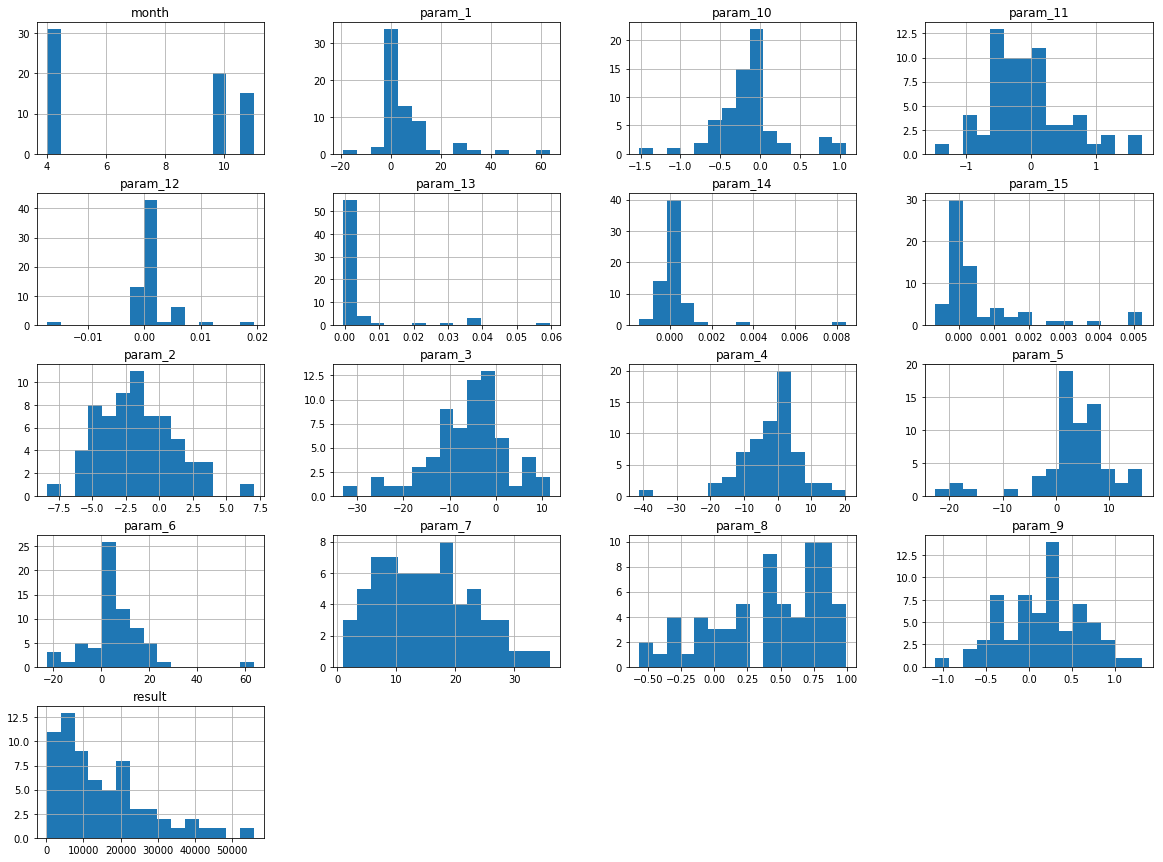

In [214]:

paramsAndRes.hist(bins=15,figsize=(20,15))
plt.show()

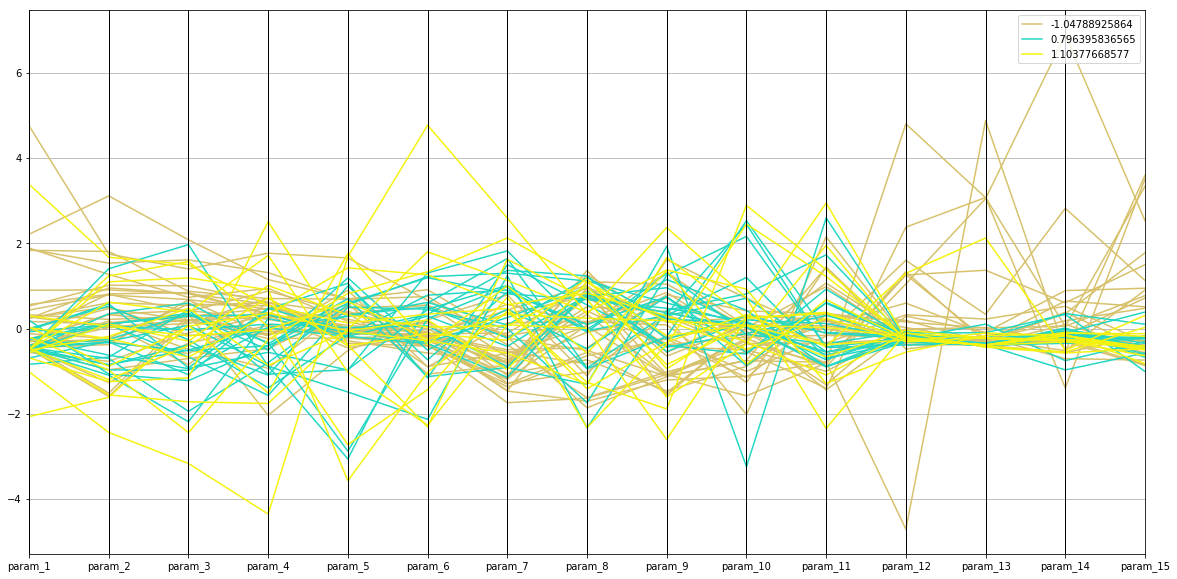

In [215]:

plt.figure(figsize=(20,10))

parallel_coordinates(((paramsAndRes-paramsAndRes.mean())/paramsAndRes.std()).drop('result',axis=1), "month")
plt.show()

In [216]:

for n in range(2, 20):
   
    
    clusterer = GMM(n_components=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    centers = clusterer.means_

    
    score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
    print('GMM silhouette score for {} clusters is {}'.format(n,score))

GMM silhouette score for 2 clusters is 0.4311841992473433
GMM silhouette score for 3 clusters is 0.36778726955431723
GMM silhouette score for 4 clusters is 0.1901057975487193
GMM silhouette score for 5 clusters is 0.2224656574286254
GMM silhouette score for 6 clusters is 0.21138255242623546
GMM silhouette score for 7 clusters is 0.22142390127048572
GMM silhouette score for 8 clusters is 0.25581231268633725
GMM silhouette score for 9 clusters is 0.23946695973021564
GMM silhouette score for 10 clusters is 0.24117619347611924
GMM silhouette score for 11 clusters is 0.19375514338320468
GMM silhouette score for 12 clusters is 0.19157573906669362
GMM silhouette score for 13 clusters is 0.17211096961456493
GMM silhouette score for 14 clusters is 0.1856956501048032
GMM silhouette score for 15 clusters is 0.16697939718628213
GMM silhouette score for 16 clusters is 0.17792922932002295
GMM silhouette score for 17 clusters is 0.16066252430314065
GMM silhouette score for 18 clusters is 0.1725998094

In [217]:

for n in range(2, 20):
    
    clusterer = KMeans(n_clusters=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

    centers = clusterer.cluster_centers_

    from sklearn.metrics import silhouette_score
    score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
    print('KMean silhouette score for {} clusters is {}'.format(n,score))

KMean silhouette score for 2 clusters is 0.2646834260162574
KMean silhouette score for 3 clusters is 0.35382085316031786
KMean silhouette score for 4 clusters is 0.27811113934218706
KMean silhouette score for 5 clusters is 0.31933798598986085
KMean silhouette score for 6 clusters is 0.32467446098314023
KMean silhouette score for 7 clusters is 0.31951302224111333
KMean silhouette score for 8 clusters is 0.25581231268633725
KMean silhouette score for 9 clusters is 0.25711808583525664
KMean silhouette score for 10 clusters is 0.2440948654336827
KMean silhouette score for 11 clusters is 0.23942023796431638
KMean silhouette score for 12 clusters is 0.23638701762996334
KMean silhouette score for 13 clusters is 0.2301951075524651
KMean silhouette score for 14 clusters is 0.23630712292208964
KMean silhouette score for 15 clusters is 0.2175830026085042
KMean silhouette score for 16 clusters is 0.23298199064598715
KMean silhouette score for 17 clusters is 0.216044326566378
KMean silhouette score

Given both results, let's take 3 clusters with GMM (more diversity of results, more robust too)

In [218]:
clusterer = KMeans(n_clusters=6, random_state=11)

clusterer.fit(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))
   
preds = clusterer.predict(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1))

centers = clusterer.cluster_centers_

score = silhouette_score(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1), preds, random_state=1)
print('GMM silhouette score for {} clusters is {}'.format(n,score))

preds

GMM silhouette score for 19 clusters is 0.32467446098314023


array([0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 0, 0, 2, 2, 5, 0, 2,
       2, 2, 0, 0, 0, 3, 0, 0, 2, 5, 1, 5, 5, 4, 4, 4, 0, 0, 5, 0])

In [219]:
paramsAndRes = pd.concat([paramsAndRes, pd.DataFrame(pd.Series(preds, name='cluster'))],axis=1)

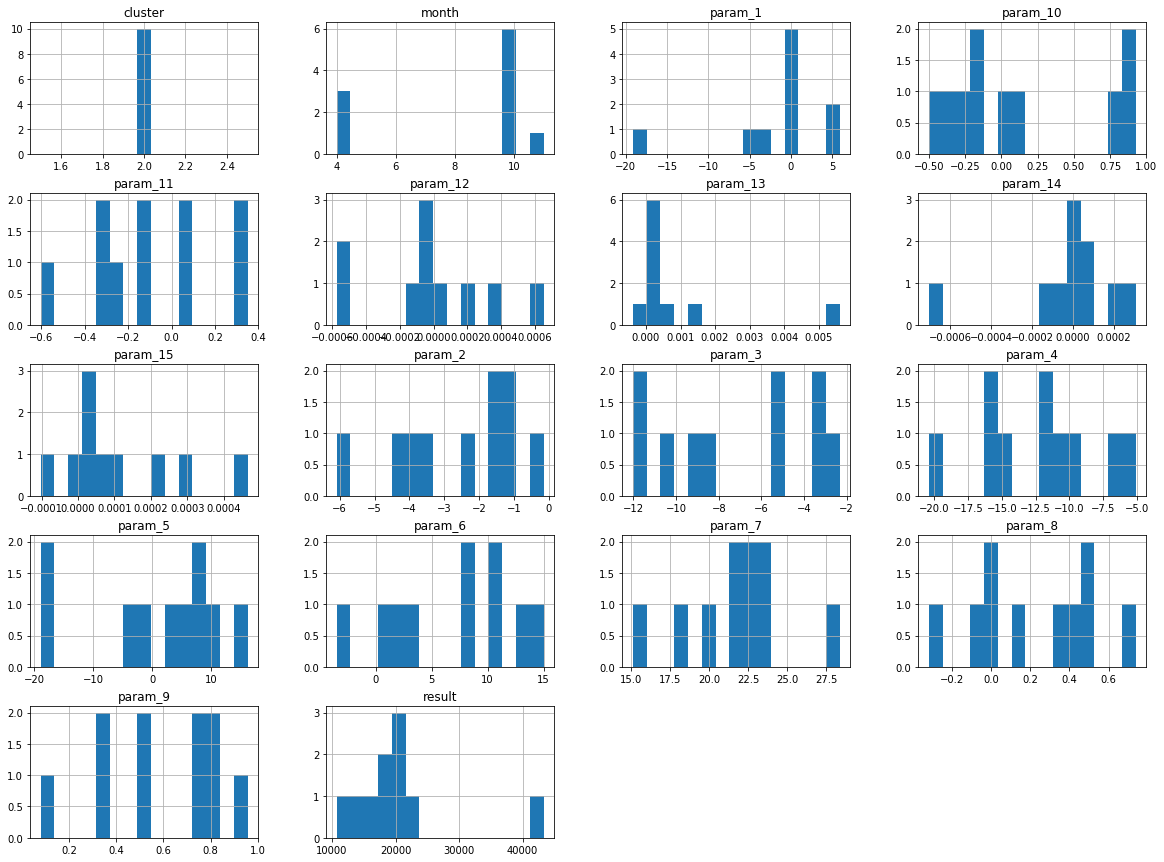

In [226]:

paramsAndRes[paramsAndRes['cluster']==2].hist(bins=15,figsize=(20,15))
plt.show()

In [220]:
paramsAndRes.groupby(['cluster']).describe().result

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,36.0,6963.088786,5485.927243,223.866774,2857.456389,5711.342724,8966.580417,21540.271946
1,1.0,55857.832228,NaN,55857.832228,55857.832228,55857.832228,55857.832228,55857.832228
2,10.0,20341.090430,8881.504778,10726.895697,15984.212827,18964.344635,20922.444519,43319.562998
3,6.0,18328.270858,12147.216941,3490.477938,11510.111988,17371.819722,22083.514424,38525.219031
4,8.0,26363.192414,6802.246417,14532.190727,23565.079865,28083.702843,30362.092733,34736.337342
5,5.0,32496.710168,11251.018765,21482.388774,22906.064990,30641.324384,39404.284592,48049.488102


We need to check upthere if the cluster make sense : look at the std deviation of each param, is it too high ? is there a too big min-max distance for each param to take the mean ?

In [196]:
(paramsAndRes.drop('month', axis = 1).drop('result', axis = 1).groupby(['cluster']).max()-paramsAndRes.drop('month', axis = 1).drop('result', axis = 1).groupby(['cluster']).min()).sum(axis = 1)

cluster
0    125.909610
1      0.000000
2    127.227777
3    104.039267
4    100.651699
5    123.331878
dtype: float64

In [151]:
newParams = []
for i in range(1,16):
    newParams.append(paramsAndRes.groupby(['cluster']).mean()['param_'+str(i)][0])

In [161]:
resACDMod = []
resExpo = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod.append(residualTotalModACD(newParams,initParams(False,True)))
        resExpo.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
280
280
280
280
275
280
280
280
285
285
285
290


In [227]:
print(np.mean(resACDMod))
print(np.mean(resExpo))

30602.9328412
23633.9055676


It seems we cannot perform good clustering, which is more evidence against the robustness of these paramters. Indeed, we could have hoped to find that several sets of parameters are global minima close to a global maximum, and thus, the optimizer can give different sets of optimizer when trained over different set of data. But it seems that parameters are quite far from each others and we cannot even cluster them correctly.

In [234]:
newParams2 = paramsAndRes[paramsAndRes['cluster']==0][paramsAndRes['result'] == np.min(paramsAndRes[paramsAndRes['cluster']==0]['result'])].drop('month', axis = 1).drop('result', axis = 1).drop('cluster', axis = 1).values

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [237]:
resACDMod2 = []
resExpo2 = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod2.append(residualTotalModACD(newParams2,initParams(False,True)))
        resExpo2.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
275
280
280
280
275
280
280
280
285
285
285
290


In [238]:
print(np.mean(resACDMod2))
print(np.mean(resExpo2))

39810.6277113
21169.6438117


# III. Exploratory Analysis :
What is the distribution of waiting time ?
What is the average waiting time for each time frame of the day ?
What is the sampling variance like ?
Is it changing a lot from day to day or is there consistencies ?

In [5]:
def extractOptionData(nbOfDataPoints_, aOptionStrike, data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({
                                     'received': utcToRightTMZ(datetime.utcfromtimestamp(tick['received']/1000000)),
                                     'created' : utcToRightTMZ(datetime.utcfromtimestamp(tick['created']/1000000))
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

In [232]:
optionData = pd.DataFrame(extractOptionData(200000,335,data2017110110))

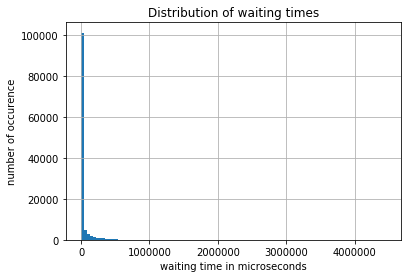

In [233]:
(optionData - optionData.shift())['created'].astype('timedelta64[us]').hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

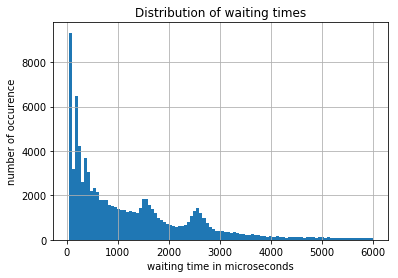

In [234]:
#closer look
dif = (optionData - optionData.shift()).astype('timedelta64[us]')
dif[dif['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

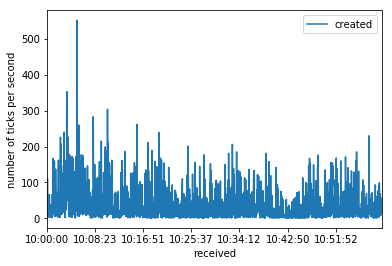

In [235]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()
#optionData2 = optionData2.mean(axis=1)

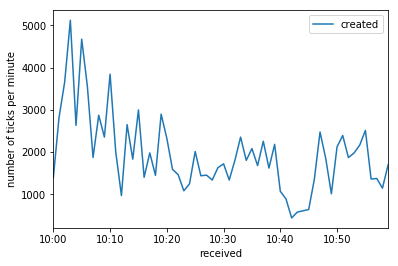

In [236]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per minute')
plt.show()

In [237]:
with gzip.open('data\\2017.11.01\\feeddata_13.json.gz', "rb") as f:
    data2017110113 = json.loads(f.read().decode("ascii")) 

In [242]:
optionData13 = pd.DataFrame(extractOptionData(200000,335,data2017110113))

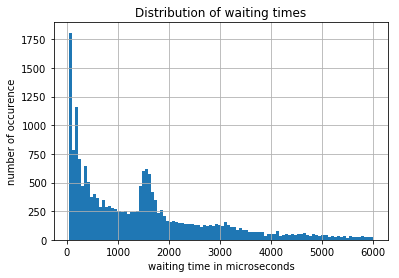

In [243]:
#closer look
dif13 = (optionData13 - optionData13.shift()).astype('timedelta64[us]')
dif13[dif13['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

A few interesting phenomena to investigate : what is this spike of occurences at 1.5ms for both hours?  It happens for both timeframes. 
Also, the market looks less busy at 13:00 than at 10:00. It makes sense.

In [4]:
def residualExpoMovingAverage13(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(extractOptionData(200000,335,data2017110113)):
        counter = counter + 1
        try:
            
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
        except KeyError:
            print(tick)
            
    return np.mean(errs)

In [247]:
residualExpoMovingAverage13(res_bench2.x)

23632.943847811337

In [248]:
res_bench_test = optimize.minimize(residualExpoMovingAverage13,[res_bench2.x], method='SLSQP', options={'maxiter':30000})

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


In [249]:
print(res_bench_test)

     fun: 23632.21706746082
     jac: array([ 0.00244141])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.87905185])


In [250]:
print(res_bench2)

     fun: 3315.466151676504
     jac: array([-0.01916504])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.88340882])


#### At first sight the results seem relatively robust, the error is not really different with the version trained on the testing set and the parameter value optimized on the two different sets is not so different. Again, we are just taking a single day with the 10:00-11:00 data as a training set and the 13:00-14:00 data as a testing set.

bigger data analysis

In [6]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.01\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp    
    

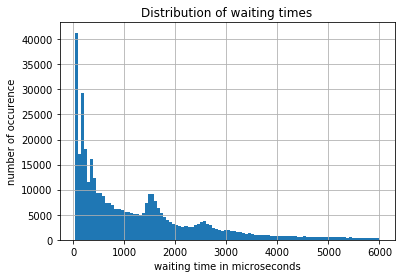

In [13]:
#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

Interestingly enough, it is very similar to subsets.

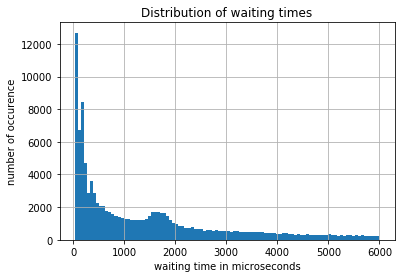

In [14]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.02\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp   

#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()    

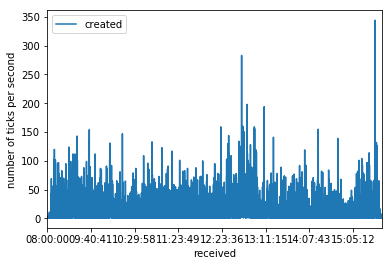

In [18]:
optionDataDay2 = optionDataDay.copy()
optionDataDay2['received'] = optionDataDay2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))
plt.figure(figsize=(20,10))
(optionDataDay2.set_index('received')-optionDataDay2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()

In [57]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    dataTemp = json.loads(f.read().decode("ascii"))
    dataTemp = pd.DataFrame(dataTemp)[(pd.DataFrame(dataTemp)['book']=='KR4201MB3355') & (pd.DataFrame(dataTemp)['type']=='tick')].drop('book', axis=1).drop('price', axis=1).drop('type', axis=1).drop('volume', axis=1).drop('received', axis=1).reset_index()

In [58]:

dataTemp.drop(list(filter(lambda x: ('ask_p' in x) or ('bid_p' in x), dataTemp.columns)), axis=1, inplace=True)

In [70]:
dataTemp['created'] = (dataTemp['created']/1000000).apply(lambda x: datetime.utcfromtimestamp(x))

In [72]:
dataTemp['created'] = dataTemp['created'].apply(lambda x: utcToRightTMZ(x))

In [73]:
dataTemp['created'] = dataTemp['created'].apply(dt.date.strftime, args=('%H:%M:%S',))
dataTemp.set_index('created', inplace=True)
dataTemp.drop('index', axis=1, inplace=True)

In [84]:
dataTemp = (dataTemp- dataTemp.shift())

In [102]:
dataTemp = dataTemp[(dataTemp!=0).apply(np.sum, axis=1)==1]

In [104]:
dataTemp = dataTemp.groupby(['created']).mean()

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


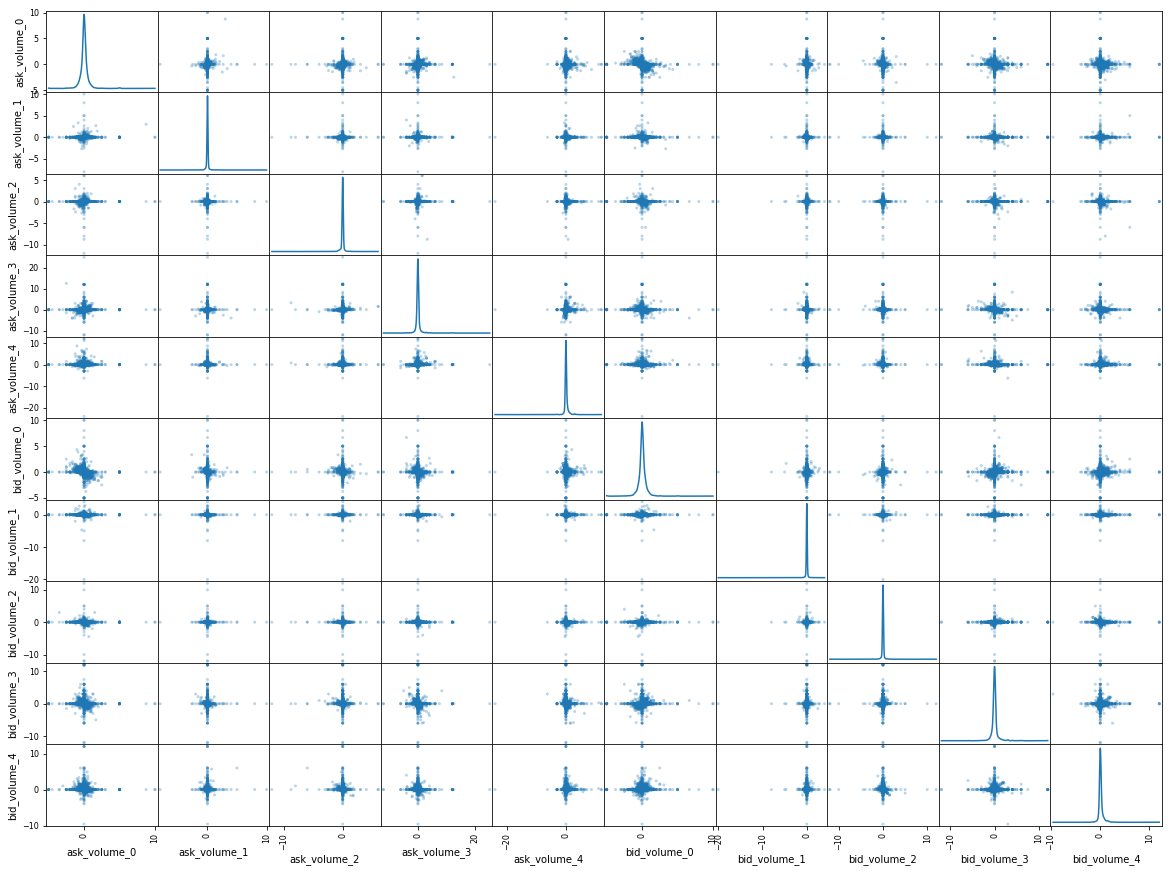

In [110]:
pd.scatter_matrix(dataTemp, alpha = 0.3, figsize = (20,15), diagonal = 'kde')
plt.show()

In [ ]:
#we can add a few things in modACD : binary data of "does the midprice changed" 

# TensorFlow 

We need to rewrite the loss function to work with tensorflow. It is good as it enables me to have easy GPU computation power and potential strong ML tools.

In [5]:
#imports
import tensorflow as tf

if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

We need to format all our data beforehand, the same way we did before, so for a first try, we can use : myDataForRun
However, the data wasn't fully formatted, as the values we are trying to learn are not yet calculated. Additionally, tensorflow requires to be in a numpy array format:
Let's first calculate them, we will need to slighly change our functions : 

In [6]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
 
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
#             if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 my
#                 myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
#                                      'type' : 'lastdone',
#                                      'volume' : tick['volume'],
#                                      'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                     })
                
#             elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
#                     myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
#                                      'type' : 'lastdone',
#                                      'volume' : tick['volume'],
#                                      'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                     })
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    try:
                        myTicksOfInterest = np.append( myTicksOfInterest,(datetime.utcfromtimestamp(tick['created']/1000000)-oldTime).microseconds/1000 )
                    except Exception as e:
                        print(e)
                        pass #pass, not continue, continue switch to the next itirqtion
                    oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

For now, let's only use the same kind of data, to be compared with our models: i.e. only time series or times.

In [7]:
arr = np.empty(shape = (0,0))

In [8]:
arr = np.append([10],[10])

In [9]:
arr = np.vstack((arr,np.array([10,10])))

In [10]:
arr

array([[10, 10],
       [10, 10]])

In [138]:
onlyWaitingTime = np.log(extractInterestingData(6000,whichStrikeAtMoney(data),data))

local variable 'oldTime' referenced before assignment


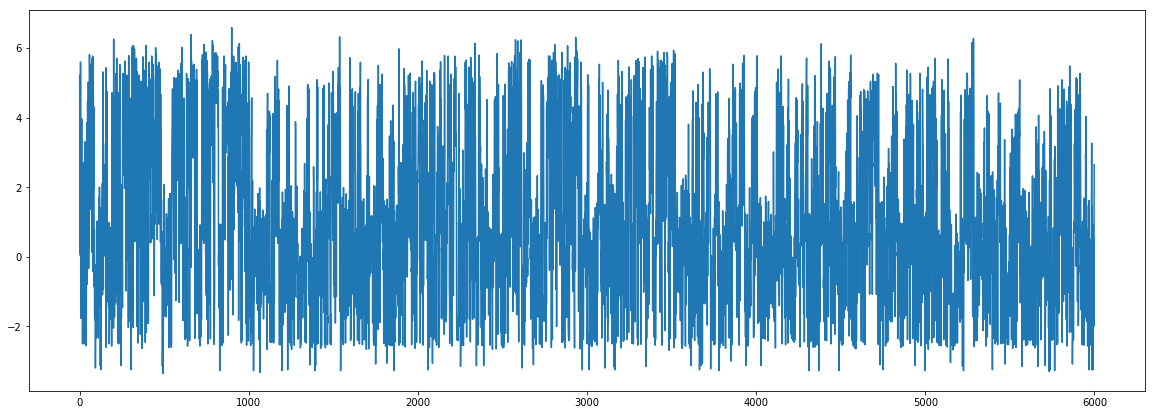

In [140]:
plt.figure(figsize=(20,7))
plt.plot(onlyWaitingTime)
plt.show()

In [326]:
tf.reset_default_graph()

In [327]:
def next_batch(data,batch_size,steps,return_index=False):
        
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size, 1), dtype = 'int64')

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    y_batch = data[batch_indices]

    # Format for RNN
    if return_index:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_indices

    else:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

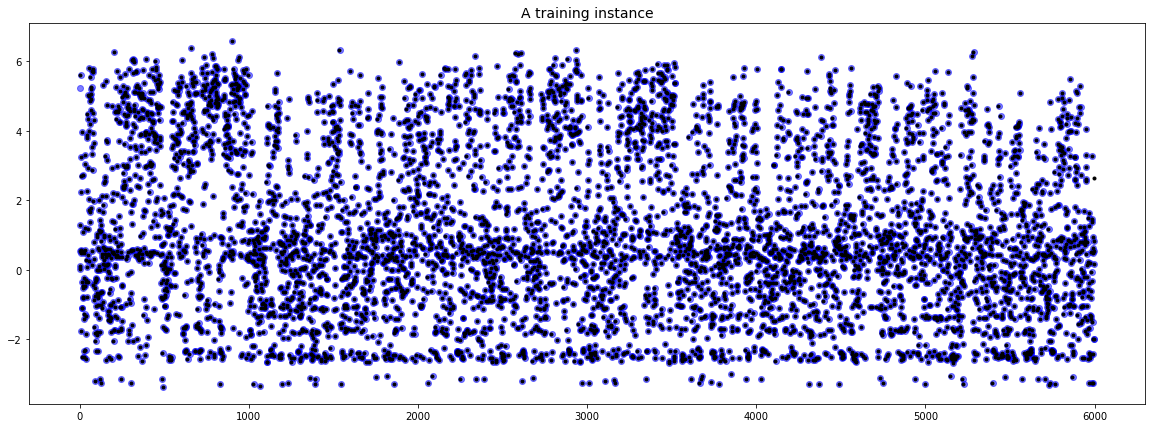

In [328]:
plt.figure(figsize=(20,7))
plt.title("A training instance", fontsize=14)
plt.plot(onlyWaitingTime[:-1], "bo", markersize=6,alpha=0.5 ,label="instance")
plt.plot(onlyWaitingTime[1:], "ko", markersize=3, label="target")
plt.show()

In [329]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 40000
# Size of the batch of data
batch_size = 1000

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 10

In [330]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


In [331]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_layers = 2

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
#           for layer in range(n_layers)])


cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
          for layer in range(n_layers)])

In [332]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [333]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [334]:
init = tf.global_variables_initializer()

In [335]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [336]:
saver = tf.train.Saver()

In [337]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(onlyWaitingTime, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 500 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 6.84232
500 	MSE: 5.10444
1000 	MSE: 4.99807
1500 	MSE: 5.05228
2000 	MSE: 5.03433
2500 	MSE: 5.0036
3000 	MSE: 5.07005
3500 	MSE: 5.04608
4000 	MSE: 4.89328
4500 	MSE: 4.88104
5000 	MSE: 4.79029
5500 	MSE: 4.80662
6000 	MSE: 4.77747
6500 	MSE: 4.73936
7000 	MSE: 4.70427
7500 	MSE: 4.67116
8000 	MSE: 4.8739
8500 	MSE: 4.84194
9000 	MSE: 4.57389
9500 	MSE: 4.60076
10000 	MSE: 4.73282
10500 	MSE: 4.77275
11000 	MSE: 4.80345
11500 	MSE: 4.59513
12000 	MSE: 4.65846
12500 	MSE: 4.63314
13000 	MSE: 4.50581
13500 	MSE: 4.80383
14000 	MSE: 4.54001
14500 	MSE: 4.68711
15000 	MSE: 4.5564
15500 	MSE: 4.75792
16000 	MSE: 4.7163
16500 	MSE: 4.55214
17000 	MSE: 4.58318
17500 	MSE: 4.51741
18000 	MSE: 4.72156
18500 	MSE: 4.76658
19000 	MSE: 4.56106
19500 	MSE: 4.50715
20000 	MSE: 4.70732
20500 	MSE: 4.77331
21000 	MSE: 4.53274
21500 	MSE: 4.6187
22000 	MSE: 4.67011
22500 	MSE: 4.55615
23000 	MSE: 4.41508
23500 	MSE: 4.66994
24000 	MSE: 4.50414
24500 	MSE: 4.5633
25000 	MSE: 4.56885
25500 	MSE

In [338]:
startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())
startTime

array(19)

In [339]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   
    X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [346]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[:-1]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

def returnPred(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


4.173746030181322


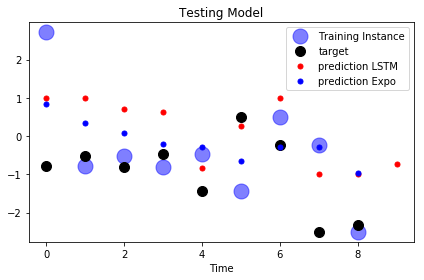

In [347]:
plt.title("Testing Model")

# Training Instance
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

# Models Prediction
plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [348]:
def showOtherGraph():
    startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())

    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
        y_pred = sess.run(outputs, feed_dict={X: X_new})

    plt.title("Testing Model")

    # Training Instance
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

    # Target to Predict
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

    # Models Prediction
    plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

    plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


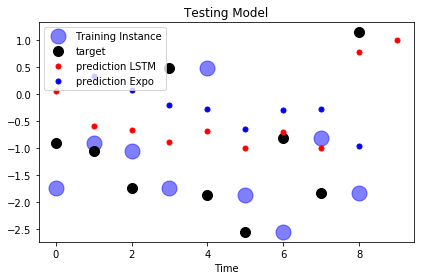

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


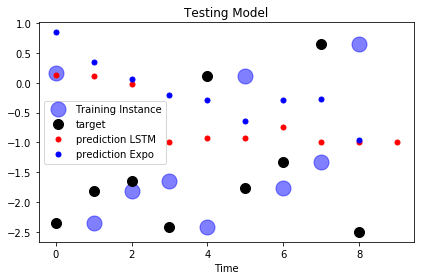

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


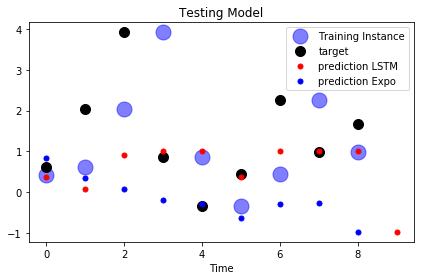

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


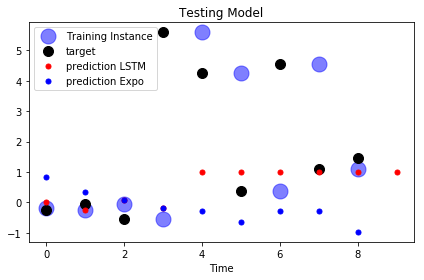

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


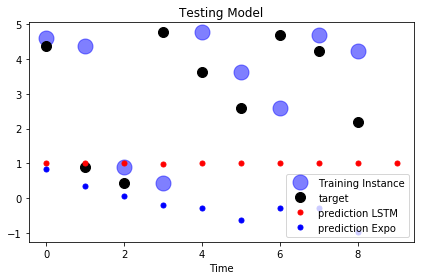

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


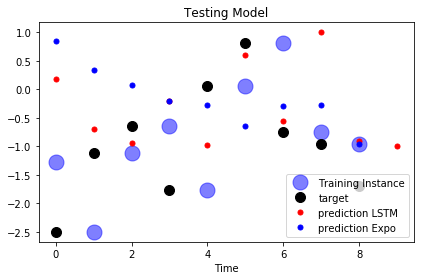

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


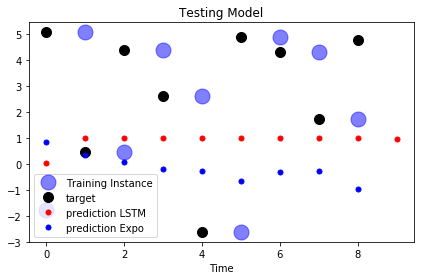

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


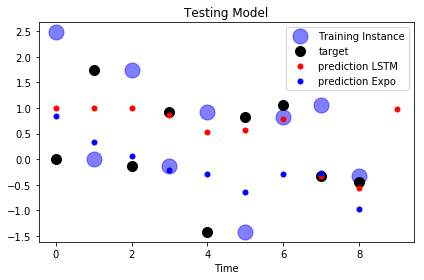

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


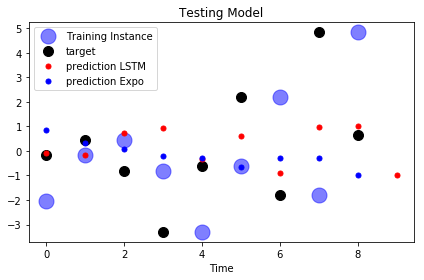

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


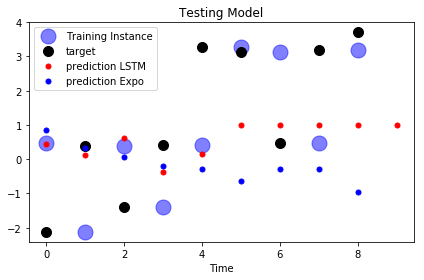

In [349]:
for i in range(0,10):
    showOtherGraph()

In [381]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
#             if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 my
#                 myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
#                                      'type' : 'lastdone',
#                                      'volume' : tick['volume'],
#                                      'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                     })
        
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myLastVol = 0.1*myLastVol + 0.9*(tick['volume'])
                    timeOfTrade = datetime.utcfromtimestamp(tick['created']/1000000)
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    try:
                        
                        currTime = datetime.utcfromtimestamp(tick['created']/1000000)
                        if len(myTicksOfInterest) == 0 :
                            myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) ])
                        else:
                            myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) ])) )

                    except Exception as e:
                        print(e)
                        pass #pass, not continue, continue switch to the next itirqtion
                    oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

In [382]:
WaitingTimeAndTrade = extractInterestingData(6000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment


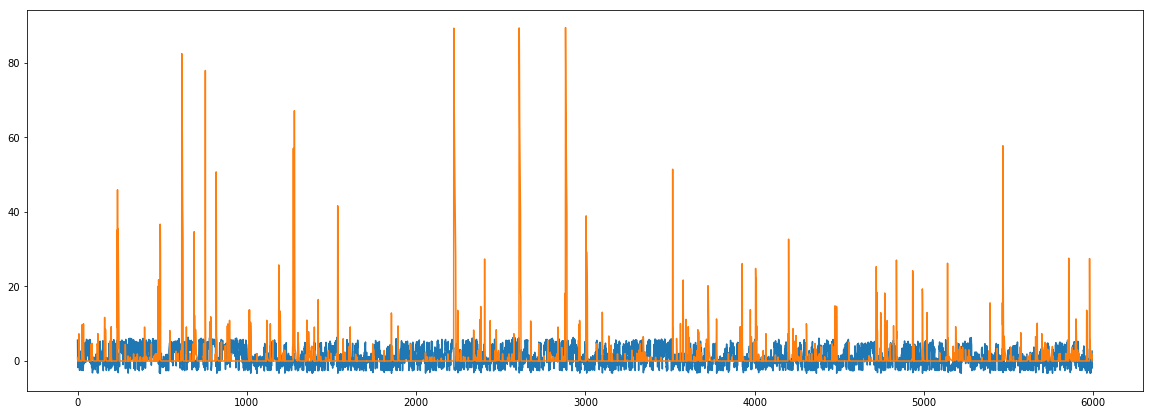

In [383]:
plt.figure(figsize=(20,7))
plt.plot(WaitingTimeAndTrade)
plt.show()

In [384]:
tf.reset_default_graph()

In [385]:
# Just one feature, the time series
num_inputs = 2
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 40000
# Size of the batch of data
batch_size = 1000

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 10


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_layers = 2

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
          for layer in range(n_layers)])

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()

In [390]:
def next_batch(data,batch_size,steps,return_index=False):
        
        #############################
        I neeed to rewrite next_batch for tensor
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size, 1,2), dtype = 'int64')

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    y_batch = data[batch_indices]

    # Format for RNN
    if return_index:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_indices

    else:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

In [389]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 500 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

ValueError: operands could not be broadcast together with shapes (1000,1,2) (11,) 